Convert to classifier model

In [1]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer 
from mingpt.utils import set_seed 
set_seed(1234)

from mingpt.model import GPT
from mingpt.trainer import Trainer
from utils import *
import datasets
from SentimentDataset import SentimentDataset

In [3]:
# Instantiate the Training Dataset
train_dataset = SentimentDataset(split="train")  # use this for the short corpus

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
val_dataset = LanguageModelingDataset(split="validation")

Reusing dataset glue (C:\Users\ephemera\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 500.25it/s]
Reusing dataset glue (C:\Users\ephemera\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 600.10it/s]


In [4]:
# Print out an example of the data - this is processed more once it reaches lm_collate_fn (above)
x,y = train_dataset[5]
print(train_dataset[5])
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",(y))

(tensor([ 5562,   705,    82,  1290,  1165, 15444,   284, 17004,   884, 31194,
         3513,   220]), 0)
X:  that 's far too tragic to merit such superficial treatment 
Y:  0


In [5]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)
# model.to(trainer.device)

modelsavename= "model_lm.pt"
model.load_state_dict(torch.load(modelsavename))

number of parameters: 2.52M


<All keys matched successfully>

In [6]:
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 3000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 8    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, collate_fn=sen_collate_fn, downstream_finetune=True)
trainer.set_callback('on_batch_end', sen_batch_end_callback)
# Train!
trainer.run()

running on device cuda
iter0 0.00ms; train loss 0.96667 acc 0.750; val loss 0.53663 acc 0.750;
iter100 25.00ms; train loss 1.22700 acc 0.375; val loss 0.86032 acc 0.500;
iter200 26.00ms; train loss 0.66918 acc 0.625; val loss 0.69271 acc 0.500;
iter300 29.00ms; train loss 0.76149 acc 0.500; val loss 0.81320 acc 0.250;
iter400 25.00ms; train loss 0.48042 acc 0.875; val loss 0.56294 acc 0.750;
iter500 27.00ms; train loss 1.20530 acc 0.500; val loss 0.59654 acc 0.625;
iter600 27.00ms; train loss 0.48220 acc 0.875; val loss 0.48014 acc 0.750;
iter700 29.00ms; train loss 0.66277 acc 0.875; val loss 0.47461 acc 0.750;
iter800 28.00ms; train loss 0.53953 acc 0.750; val loss 0.59841 acc 0.625;
iter900 26.00ms; train loss 0.62483 acc 0.625; val loss 0.52955 acc 0.750;
iter1000 29.00ms; train loss 0.54140 acc 0.750; val loss 0.55419 acc 0.875;
iter1100 27.00ms; train loss 0.33558 acc 0.875; val loss 0.65220 acc 0.625;
iter1200 33.00ms; train loss 0.63326 acc 0.625; val loss 0.49622 acc 0.750;
it

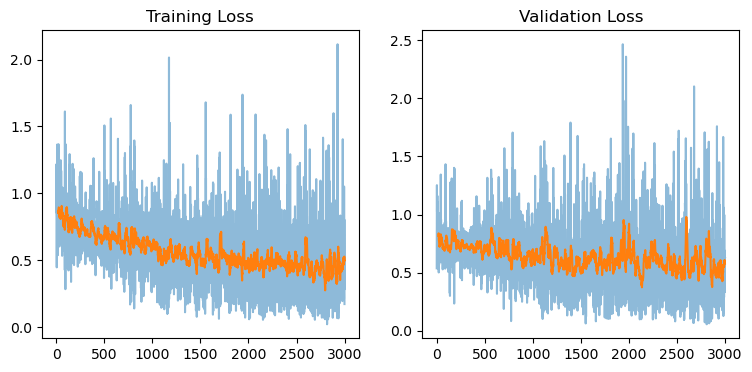

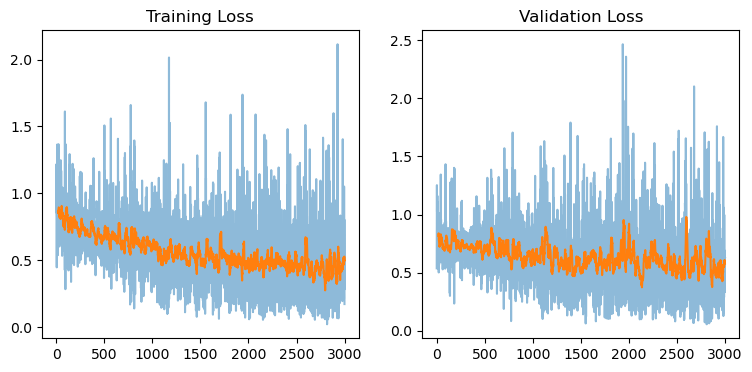

In [7]:
plot_loss(trainer)

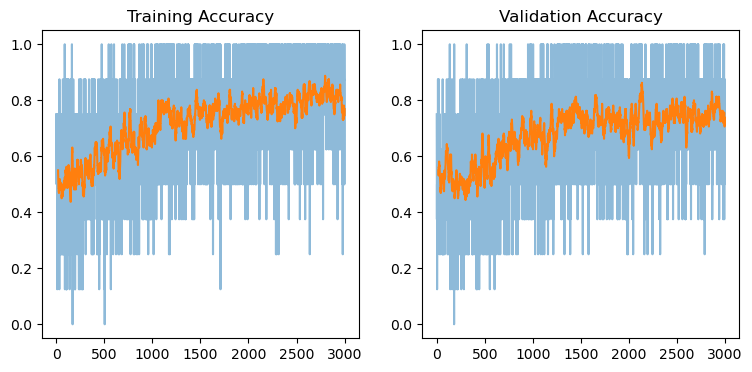

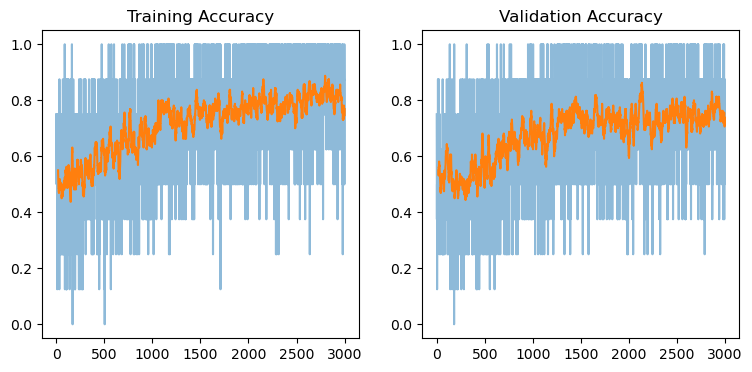

In [8]:
plot_acc(trainer)